**Part 2:** Defining transport sections over the rim of the canyon and surrounding shelf and slope.

In [1]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pickle

# Function: Download mesh mask variables

In [2]:
def get_variables_planes(dirname, filename):
    
    with nc.Dataset(os.path.join(dirname, filename), 'r') as nbl:
        x, y =  slice(1,-1,None), slice(1,-1,None)
        gdepw = nbl.variables['gdepw_1d'][0, :]
        tmask = nbl.variables['tmask'][0, :, y, x]
        mbathy = nbl.variables['mbathy'][0, y, x]
        e1t = nbl.variables['e1t'][0, y, x]
        e2t = nbl.variables['e2t'][0, y, x]  
        
        return gdepw, tmask, mbathy, e1t, e2t

In [3]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'
gdepw, tmask, mbathy, e1t, e2t = get_variables_planes(dirname, filename)
filename = '1_mesh_mask_nocanyon.nc'
gdepwn, tmaskn, mbathyn, e1tn, e2tn = get_variables_planes(dirname, filename)

In [4]:
xs = np.arange(mbathyn.shape[-1])
ys = np.arange(mbathyn.shape[-2])

mbathy.shape, e1t.shape, e2t.shape, tmask.shape

((272, 242), (272, 242), (272, 242), (80, 272, 242))

# Function: Build Surface Mask

In [5]:
def build_surface_mask(tmask_nocanyon, mbathy_nocanyon):
    
    surface_mask = np.zeros_like(tmask_nocanyon)
    for i in range(tmask_nocanyon.shape[-1]):
        for j in range(tmask_nocanyon.shape[-2]):
            k = mbathy_nocanyon[j, i]
            surface_mask[k, j, i] = 1
            
    return surface_mask

# Function: Saving Surface Mask

In [6]:
def save_surface_mask(surface_mask):
    
    file_name = 'surface_mask'
    file_object = open(file_name,'wb')
    pickle.dump(surface_mask,file_object)
    file_object.close()
    
    return file_name

def get_surface_mask(tmaskn, mbathyn):
    
    surface_mask = build_surface_mask(tmaskn, mbathyn)
    file_name = save_surface_mask(surface_mask)
    
    file_object = open(file_name,'rb')
    surface_mask_saved = pickle.load(file_object)
    
    return surface_mask_saved

In [7]:
surface_mask = get_surface_mask(tmaskn, mbathyn)

### Visualizing the curtain over the no canyon shelf/slope

In [8]:
def plot_surface_mask(surface_mask, N, deps):
    fig, ax = plt.subplots(1, N, figsize=(20, 5), sharey=True)
    ax[0].set_ylabel('y inds', fontsize=14)
    for n, dep in zip(np.arange(N), deps):
        p = ax[n].pcolormesh(surface_mask[dep, :, :], cmap=cm.hot_r)
        plt.setp( ax[n].get_xticklabels(), visible=False)
        ax[n].set_title(str(dep) + ' = ' + str(int(gdepwn[dep])) + ' m', fontsize=14)
        ax[n].grid()
        ax[n].set_xlim([0, surface_mask.shape[-1]])
        ax[n].set_ylim([0, surface_mask.shape[-2]])
        ax[n].set_xlabel('x inds', fontsize=14)
    fig.suptitle('Surface Mask at every depth index (black=1, white=0)', fontsize=18)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    ax1.plot(mbathyn[:, int(0.5*mbathyn.shape[-1])], linewidth=2, c='k')
    ax1.set_ylim([deps[-1], deps[0]])
    ax1.grid()
    ax1.set_xlabel('y inds', fontsize=14)
    ax1.set_ylabel('z inds', fontsize=14)
    ax1.set_title('depth ind profile', fontsize=14)
    ax2.pcolormesh(xs, ys, mbathyn, cmap=cm.Blues)
    c = ax2.contour(xs, ys, mbathyn, levels = deps, colors='k')
    ax2.clabel(c, inline=1, fontsize=10)
    ax2.set_xlabel('x inds', fontsize=14)
    ax2.set_ylabel('y inds', fontsize=14)
    ax2.set_title('mbathy with depth ind steps', fontsize=14)
    return fig

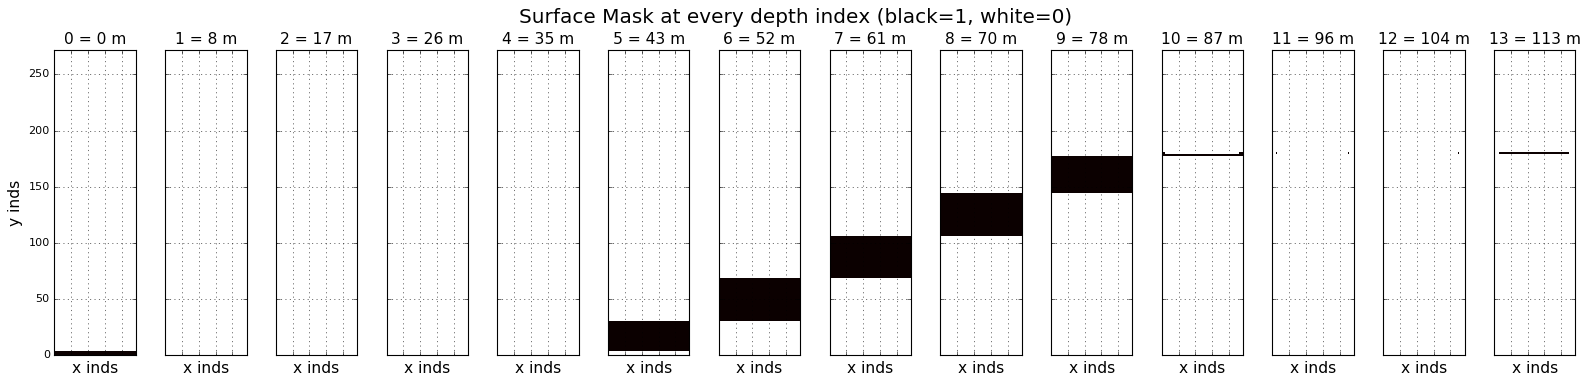

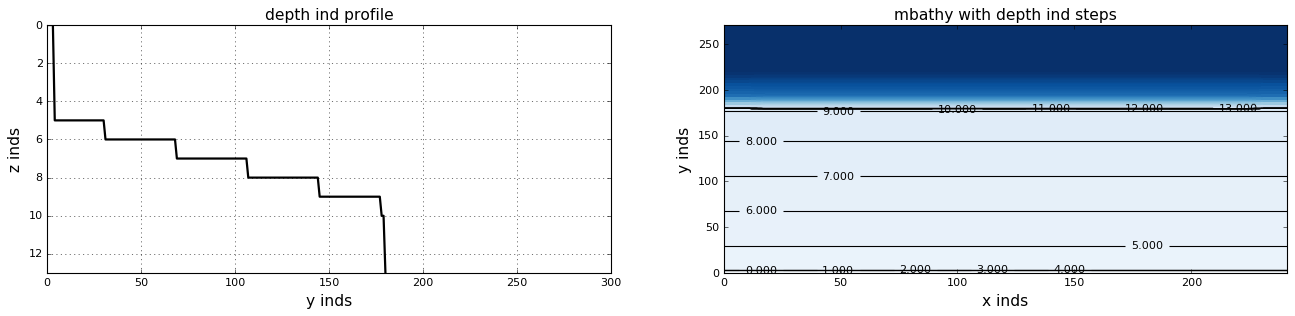

In [9]:
N = 14
deps = np.arange(0, 0+N)
fig = plot_surface_mask(surface_mask, N, deps)

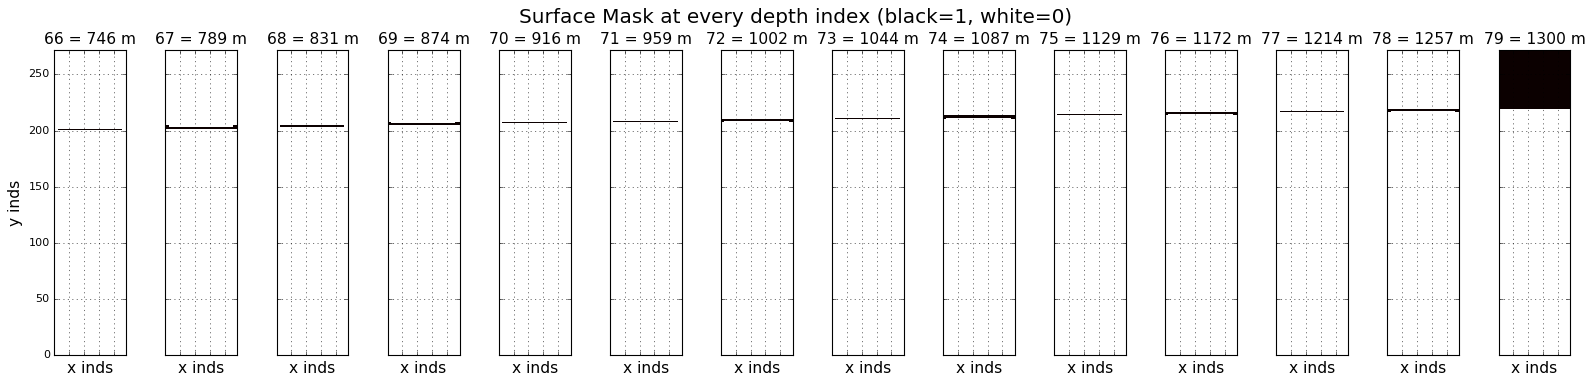

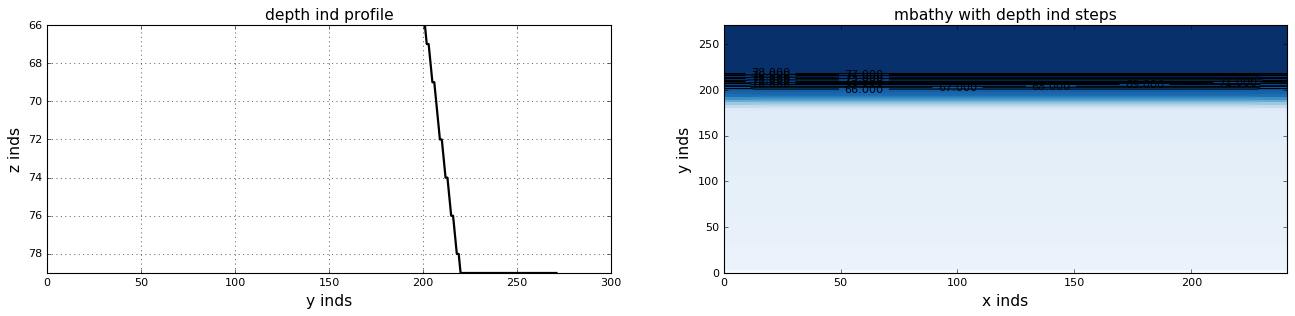

In [10]:
N = 14
deps = np.arange(66, 66+N)
fig = plot_surface_mask(surface_mask, N, deps)

# Function: Canyon Axis Indices

In [11]:
def get_index_axis(mbathy, mbathyn):

    mbathy_diff = mbathy - mbathyn
    axis_thalweg = np.zeros(mbathy_diff.shape[-2])

    for y in range(len(axis_thalweg)):
        mbathy_row = mbathy_diff[y, :]
        max_mbathy_row = mbathy_row.max()
        x_inds_max_mbathy_row = np.where(mbathy_row == max_mbathy_row)[0]
        x_ind_thalweg = int(np.median(x_inds_max_mbathy_row))
        axis_thalweg[y] = x_ind_thalweg
        
    return axis_thalweg

In [12]:
axis_thalweg = get_index_axis(mbathy, mbathyn)

# Function: Index Break

In [13]:
def get_index_break(gdepw, mbathyn):
    
    # [ 0  5  6  7  8  9 10 20 30 40 50 60 63 65 67 69 72 74 76 78 79]
    unique_z_inds = np.unique(mbathyn[:, 1])

    # [ 4 27 38 38 38 33  3  3  3  3  3  3  3  3  3  3  3  3  3  3 52]
    occurrence_z_inds = np.zeros_like(unique_z_inds)
    for i in range(len(unique_z_inds)):
        occurrence_z_inds[i] = (mbathyn[:, 1] == unique_z_inds[i]).sum()

    # [23 11  0  0  5 30  0  0  0  0  0  0  0  0  0  0  0  0  0 49]
    jumps_in_occurrence = abs(np.diff(occurrence_z_inds))

    # [array([ 1,  2,  6, 20])]
    con1 = [x+1 for x in np.where(jumps_in_occurrence > np.mean(jumps_in_occurrence))] 

    # [ 5  6 10 79]
    unique_z_inds_con1 = unique_z_inds[con1]

    # [   43.75    52.5     87.5   1300.  ]
    dep_z_inds_con1 = gdepw[unique_z_inds_con1]

    # 2
    con2 = np.argmin(np.abs(dep_z_inds_con1 - 80))

    # 10
    unique_z_inds_con1_con2 = unique_z_inds_con1[con2]

    # 178
    ind_break = np.where(mbathyn[:, 1] == unique_z_inds_con1_con2)[0][0]
    
    return ind_break

In [14]:
ind_break = get_index_break(gdepw, mbathyn)

# Function: Index Head

In [15]:
def get_index_head(gdepw, tmask, axis_thalweg):
    
    ind_shelf = np.argmin(np.abs(gdepw - 80))

    state_thalweg = np.zeros_like(axis_thalweg)
    for i in range(len(axis_thalweg)):
        state_thalweg[i] = tmask[ind_shelf, i, axis_thalweg[i]]

    ind_head = np.where(state_thalweg == 0)[0][-1]
    
    return ind_head, ind_shelf

In [16]:
ind_head, ind_shelf = get_index_head(gdepw, tmask, axis_thalweg)

# Function: Index Mid

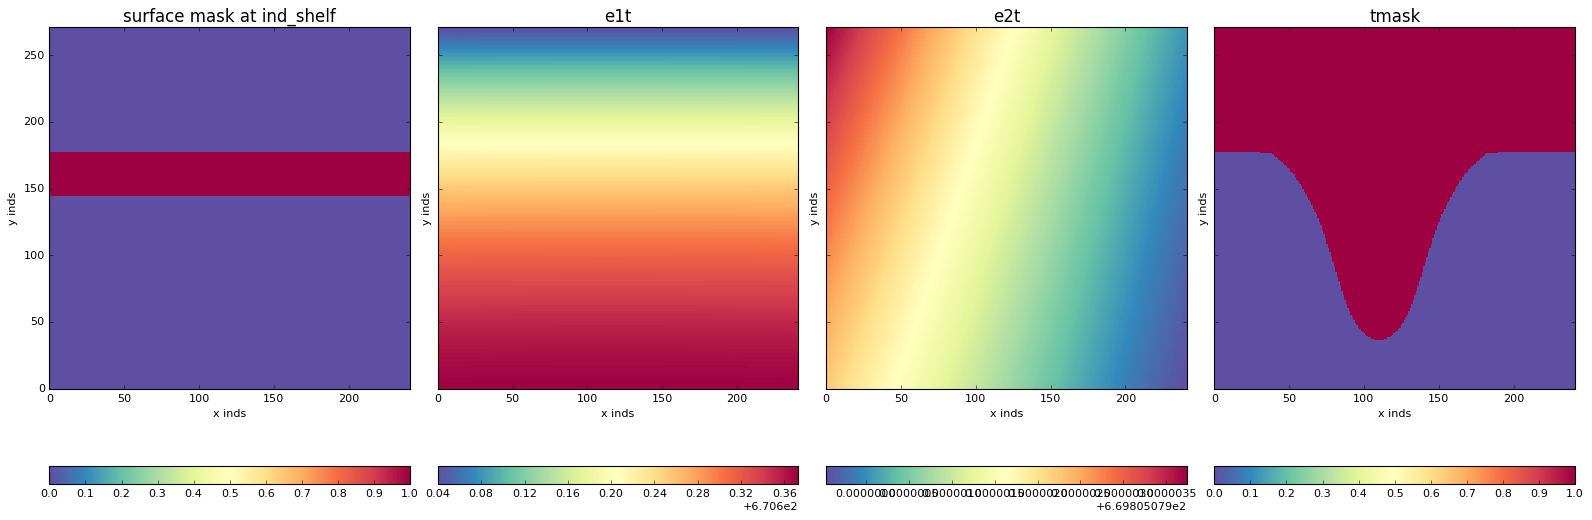

In [17]:
fig, ax = plt.subplots(1,4,figsize=(20, 7), sharey=True)
ttls = ['surface mask at ind_shelf', 'e1t', 'e2t', 'tmask']
for n, this, ttl in zip(np.arange(4), [surface_mask[ind_shelf,...], e1t, e2t, tmask[ind_shelf,...]], ttls):
    p = ax[n].pcolormesh(xs, ys, this, cmap=cm.Spectral_r)
    cbar = fig.colorbar(p, ax = ax[n], orientation='horizontal')
    ax[n].set_xlim(0, xs[-1]); ax[n].set_ylim(0, ys[-1])
    ax[n].set_title(ttl, fontsize=15)
    ax[n].set_xlabel('x inds'); ax[n].set_ylabel('y inds')
    fig.tight_layout(h_pad=0.2, w_pad=0.2)

In [18]:
def get_index_half(tmask, e1t, e2t, surface_mask):
    
    area_k0 = e1t * e2t
    area_k = area_k0 * surface_mask

    # 1. area of individual wet cells
    area_for_mid = area_k * tmask

    area_k0.shape, area_k.shape, area_for_mid.shape

    # 2. total area covered by canyon rim
    # this could change if I specify it to be between head/break
    area_canyon = area_for_mid
    total_area_canyon = np.sum(area_canyon)

    # 3. half the area of the canyon
    half_area_canyon = total_area_canyon / 2

    area_canyon.shape, total_area_canyon

    # 4. area at all depths and all ys
    area_all = np.zeros(area_canyon.shape[-3] * area_canyon.shape[-2])
    n = 0
    for depth_ind in range(area_canyon.shape[-3]):
        for y_ind in range(area_canyon.shape[-2]):
            area_all[n] = np.sum(area_canyon[depth_ind, y_ind, :])
            n += 1 

    # 5. relative y_ind where cumulative area is closest to the half area
    cumsum_area_canyon = np.cumsum(area_all)
    relative_ind_half = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()

    # 6. the real y_ind for half area
    coord_ind_half = relative_ind_half / area_canyon.shape[-2]
    z_ind_half = int(coord_ind_half)
    ind_half = relative_ind_half - (z_ind_half * area_canyon.shape[-2])
    
    return ind_half, area_k, area_k0, area_canyon, area_all, cumsum_area_canyon

In [19]:
ind_half, area_k, area_k0, area_canyon, area_all, cumsum_area_canyon = get_index_half(tmask, e1t, e2t, surface_mask)

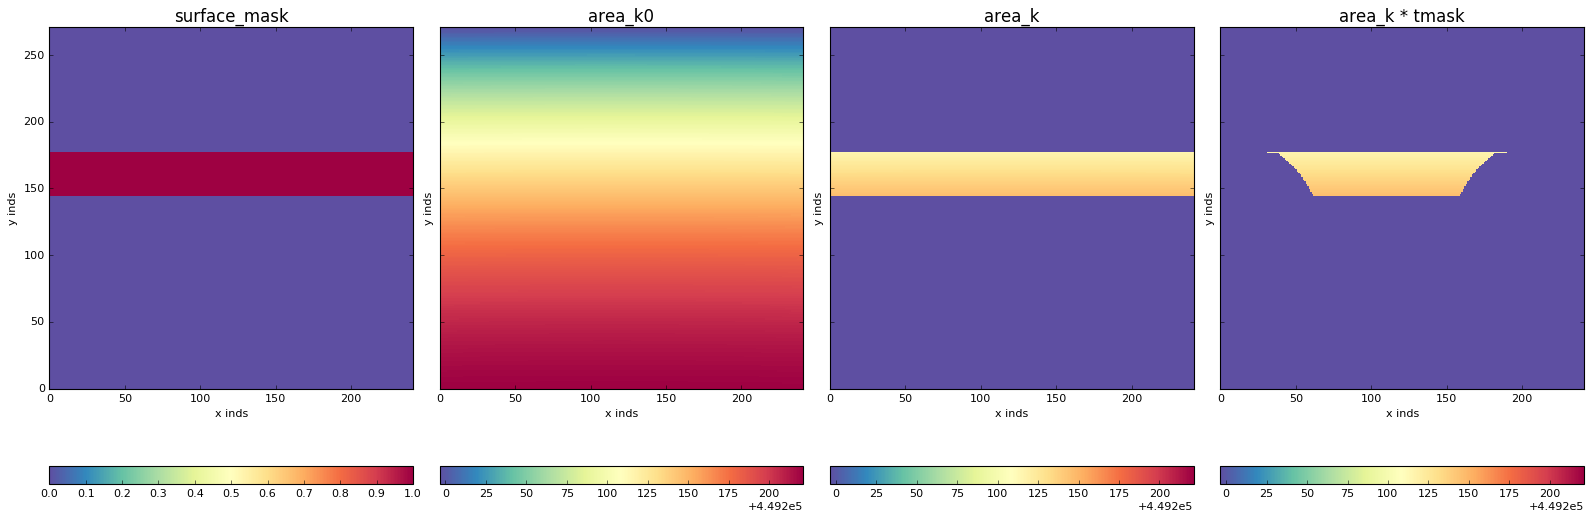

In [27]:
vmin = area_k0.min()
vmax = area_k0.max()

fig, ax = plt.subplots(1,4,figsize=(20, 7), sharey=True)
ttls = ['surface_mask', 'area_k0', 'area_k', 'area_k * tmask']
these = [surface_mask[ind_shelf,...], area_k0, area_k[ind_shelf,...], area_canyon[ind_shelf,...]]
for n, this, ttl in zip(np.arange(4), these, ttls):
    if n==0:
        p = ax[n].pcolormesh(xs, ys, this, cmap=cm.Spectral_r)
    else:
        p = ax[n].pcolormesh(xs, ys, this, cmap=cm.Spectral_r, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(p, ax = ax[n], orientation='horizontal')
    ax[n].set_xlim(0, xs[-1]); ax[n].set_ylim(0, ys[-1])
    ax[n].set_title(ttl, fontsize=15)
    ax[n].set_xlabel('x inds'); ax[n].set_ylabel('y inds')
    fig.tight_layout(h_pad=0.2, w_pad=0.2)

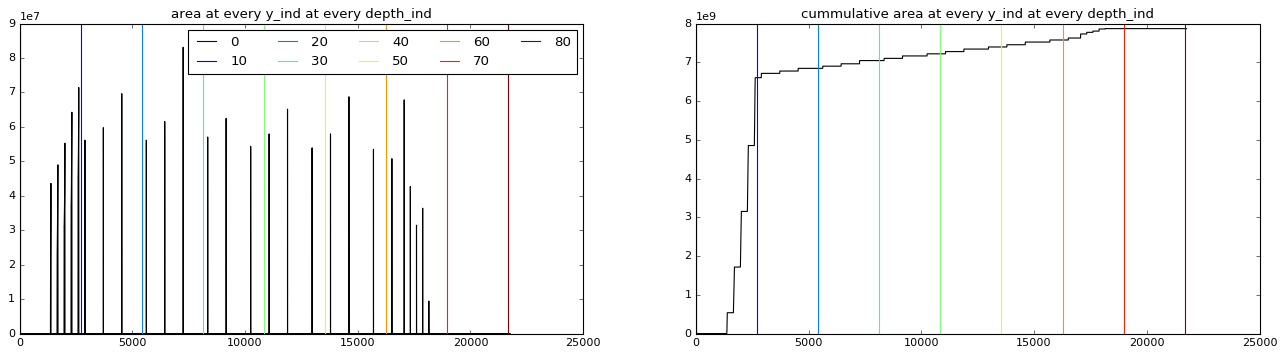

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 5))
ax1.plot(area_all, c='k')
ax2.plot(cumsum_area_canyon, c = 'k')
colors = cm.jet(np.linspace(0, 1, 81))
for i in range(81)[::10]:
    ax1.axvline(i*271, c=colors[i], label=str(i))
    ax2.axvline(i*271, c=colors[i])
ax1.set_title('area at every y_ind at every depth_ind')
ax2.set_title('cummulative area at every y_ind at every depth_ind')
ax1.legend(ncol=5)

### Visualizing thalweg and mbathy_diff

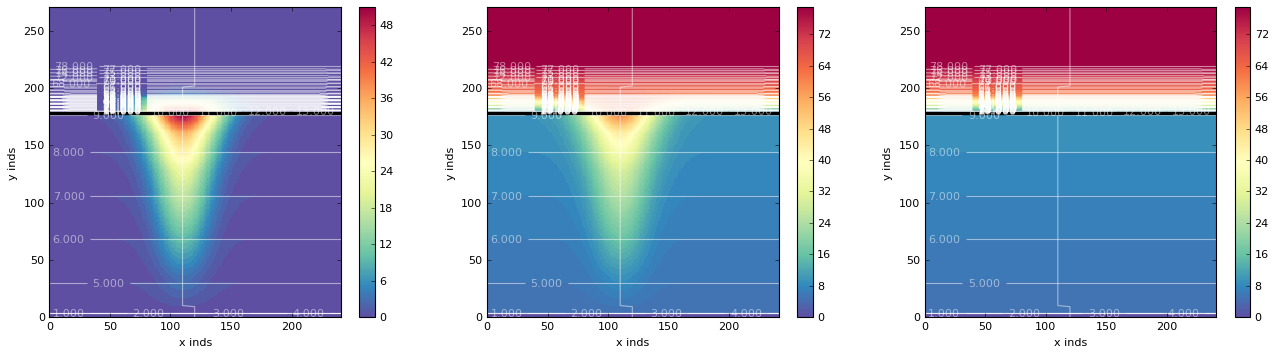

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
for ax, this in zip([ax1, ax2, ax3], [mbathy - mbathyn, mbathy, mbathyn]):
    p = ax.pcolormesh(xs, ys, this, cmap=cm.Spectral_r)
    ax.set_xlim(0, xs[-1]); ax.set_ylim(0, ys[-1])
    fig.colorbar(p, ax=ax)
    c = ax.contour(mbathyn, 80, colors='w', alpha=0.5)
    ax.clabel(c)
    ax.plot(axis_thalweg, ys, c='w', alpha=0.5)
    ax.axhline(ind_break, c='k', linewidth=3)
    ax.set_xlabel('x inds'); ax.set_ylabel('y inds')

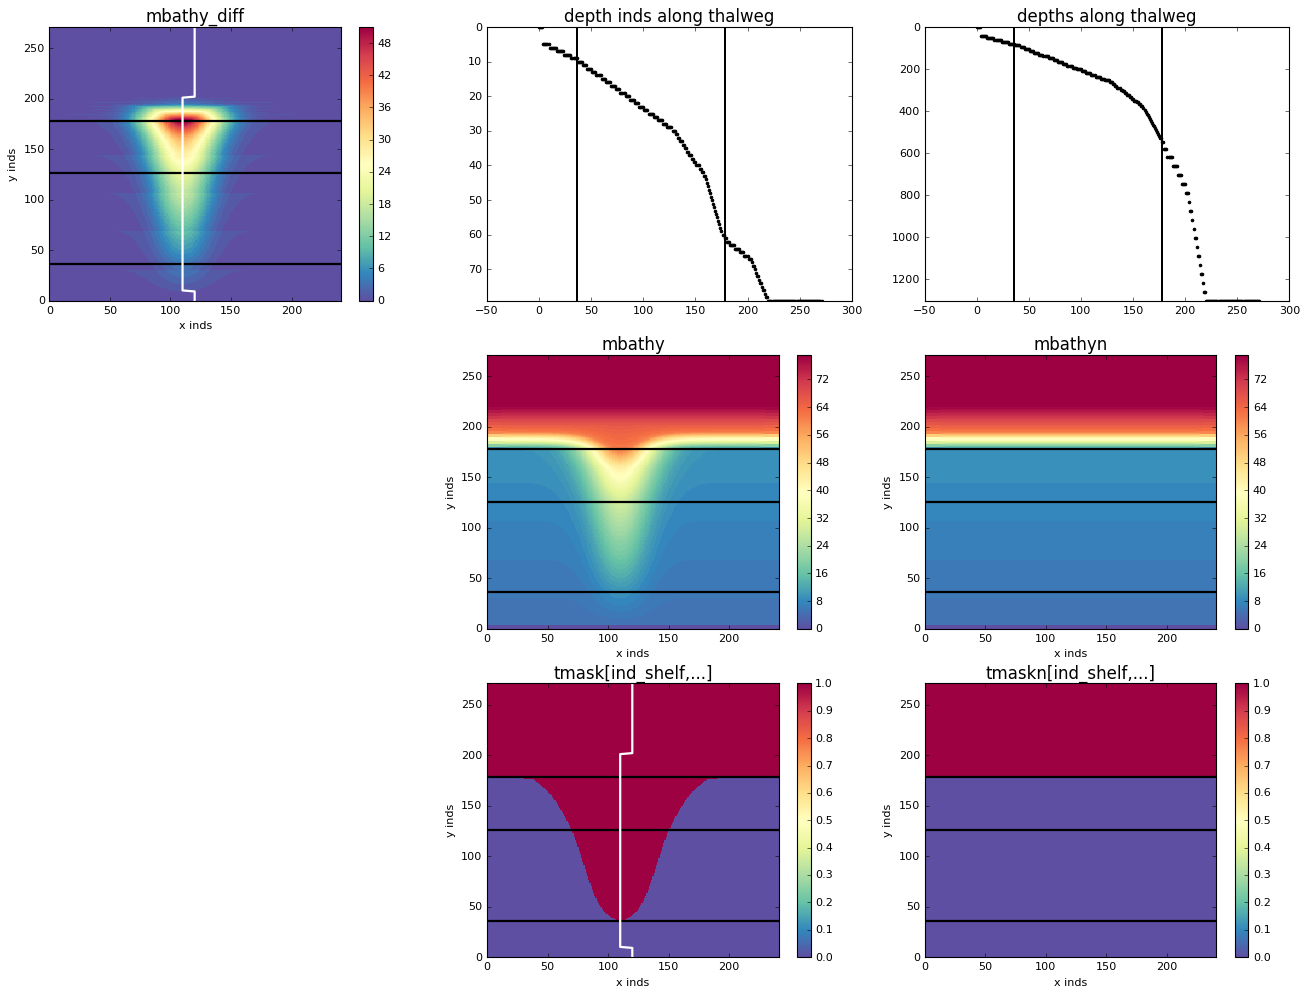

In [26]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]) = plt.subplots(3,3,figsize=(20,15))
mbathy_diff = mbathy - mbathyn

for ax, this in zip([ax1, ax5, ax6, ax8, ax9], [mbathy_diff, mbathy, mbathyn,
                                                tmask[ind_shelf, ...], tmaskn[ind_shelf, ...]]):
    p = ax.pcolormesh(xs, ys, this, cmap=cm.Spectral_r)
    ax.set_xlim(0, xs[-1]); ax.set_ylim(0, ys[-1])
    fig.colorbar(p, ax=ax)
    ax.set_xlabel('x inds'); ax.set_ylabel('y inds')
    ax.axhline(ind_break, c='k', linewidth=2)
    ax.axhline(ind_head, c='k', linewidth=2)
    ax.axhline(ind_half, c='k', linewidth=2)

for x, y in zip(axis_thalweg, ys):
    for ax, this in zip([ax2, ax3], [mbathy[y,x], gdepw[mbathy[y,x]]]):
        ax.scatter(y, this, c='k', marker='.')
        ax.axvline(ind_break, c='k', linewidth=0.2)
        ax.axvline(ind_head, c='k', linewidth=0.2)
        ax.set_ylim([this.max(), 0])
    
ax1.plot(axis_thalweg, ys, c='w', linewidth=2)
ax8.plot(axis_thalweg, ys, c='w', linewidth=2)
ax4.set_axis_off()
ax7.set_axis_off()

ttls = ['mbathy_diff', 'depth inds along thalweg', 'depths along thalweg', 'mbathy', 'mbathyn',
        'tmask[ind_shelf,...]', 'tmaskn[ind_shelf,...]']
for ax, ttl in zip([ax1, ax2, ax3, ax5, ax6, ax8, ax9], ttls):
    ax.set_title(ttl, fontsize=15)

# Function: All

In [28]:
def get_indices_V(gdepw, tmask, tmaskn, mbathy, mbathyn, e1t, e2t):
    
    surface_mask = get_surface_mask(tmaskn, mbathyn)
    
    axis_thalweg = get_index_axis(mbathy, mbathyn)
    
    ind_break = get_index_break(gdepw, mbathyn)
    
    ind_head, ind_shelf = get_index_head(gdepw, tmask, axis_thalweg)
    
    ind_half, area_k, area_k0, area_canyon, area_all, cumsum_area_canyon = get_index_half(tmask, e1t, e2t, surface_mask)
    
    return surface_mask, axis_thalweg, ind_break, ind_head, ind_shelf, ind_half, area_k, area_k0